## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [282]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import time

### Data quality check
*By Lilly Sorkin*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [283]:
# getting numeric/continuous predictors
continuous = []
for col in movie_industry.columns:
    if movie_industry.dtypes[col] != object:
        continuous.append(col)
continuous.remove('gross')
continuous        

['year', 'score', 'votes', 'budget', 'runtime']

Text(0, 0.5, 'Count')

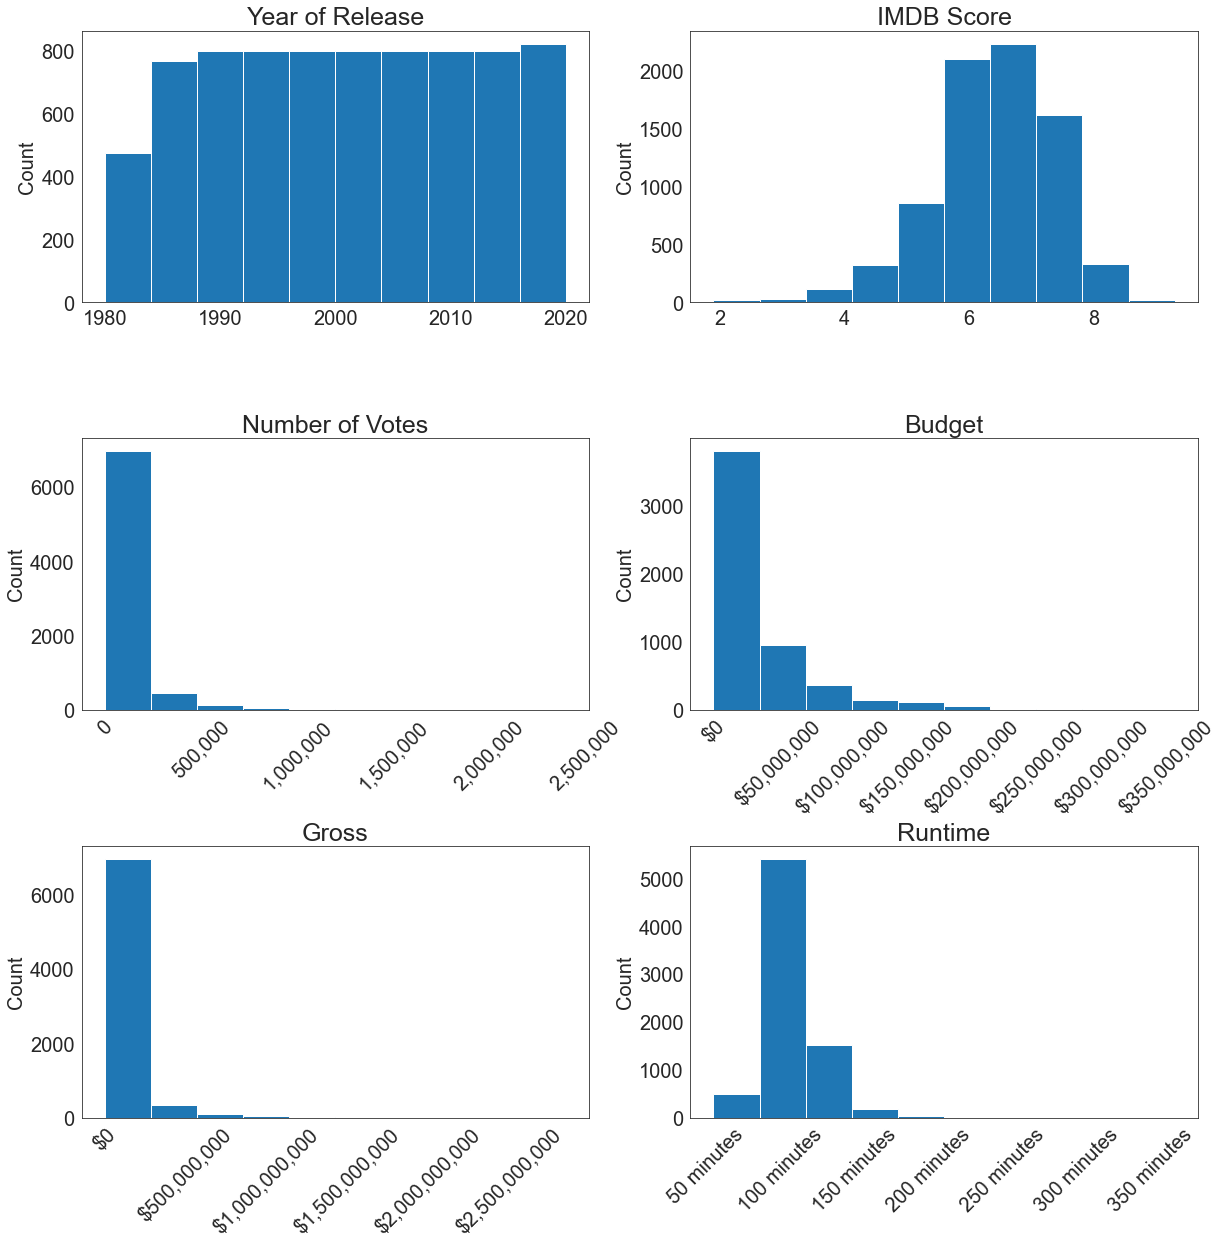

In [284]:
#plotting numeric predictors against count to show distribution
sns.set_style('white')
fig, axes = plt.subplots(3,2,figsize=(20,20))
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.5)

axes[0,0].hist(movie_industry.year)
axes[0,0].set_title('Year of Release', fontsize=25)
axes[0,0].tick_params(axis = 'both',labelsize=20)
axes[0,0].set_ylabel('Count', fontsize=20)

axes[0,1].hist(movie_industry.score)
axes[0,1].set_title('IMDB Score', fontsize=25)
axes[0,1].tick_params(axis = 'both',labelsize=20)
axes[0,1].set_ylabel('Count', fontsize=20)

axes[1,0].hist(movie_industry.votes)
axes[1,0].set_title('Number of Votes', fontsize=25)
axes[1,0].tick_params(axis = 'both',labelsize=20)
axes[1,0].xaxis.set_major_formatter('{x:,.0f}')
axes[1,0].tick_params(axis='x', labelrotation=45)
axes[1,0].set_ylabel('Count', fontsize=20)

axes[1,1].hist(movie_industry.budget)
axes[1,1].set_title('Budget', fontsize=25)
axes[1,1].tick_params(axis = 'both',labelsize=20)
axes[1,1].xaxis.set_major_formatter('${x:,.0f}')
axes[1,1].tick_params(axis='x', labelrotation=45)
axes[1,1].set_ylabel('Count', fontsize=20)

axes[2,0].hist(movie_industry.gross)
axes[2,0].set_title('Gross', fontsize=25)
axes[2,0].tick_params(axis = 'both',labelsize=20)
axes[2,0].xaxis.set_major_formatter('${x:,.0f}')
axes[2,0].tick_params(axis='x', labelrotation=45)
axes[2,0].set_ylabel('Count', fontsize=20)


axes[2,1].hist(movie_industry.runtime)
axes[2,1].set_title('Runtime', fontsize=25)
axes[2,1].tick_params(axis = 'both',labelsize=20)
axes[2,1].xaxis.set_major_formatter('{x:.0f} minutes')
axes[2,1].tick_params(axis='x', labelrotation=45)
axes[2,1].set_ylabel('Count', fontsize=20)

In [307]:
#getting categoric variables that have a reasonable number of different values
categorical = []
for col in movie_industry.columns:
    if movie_industry.dtypes[col] == object:
        categorical.append(col)
categorical.remove('name')
categorical.remove('director')
categorical.remove('released')
categorical.remove('star')
categorical        

['rating', 'genre', 'writer', 'country', 'company']

In [286]:
#reducing number of values being plotted so that it's readable
companies = pd.DataFrame(columns=['Company', 'Count'])
companies['Company'] = movie_industry_clean.company.unique()
companies['Count'] = list(movie_industry_clean.company.value_counts(sort=False))
repeated_companies = companies.loc[companies.Count>20]

In [287]:
#reducing number of values being plotted so that it's readable
countries = pd.DataFrame(columns=['Country', 'Count'])
countries['Country'] = movie_industry_clean.country.unique()
countries['Count'] = list(movie_industry_clean.country.value_counts(sort=False))
repeated_countries = countries.loc[countries.Count>3]

Text(0, 0.5, 'Count')

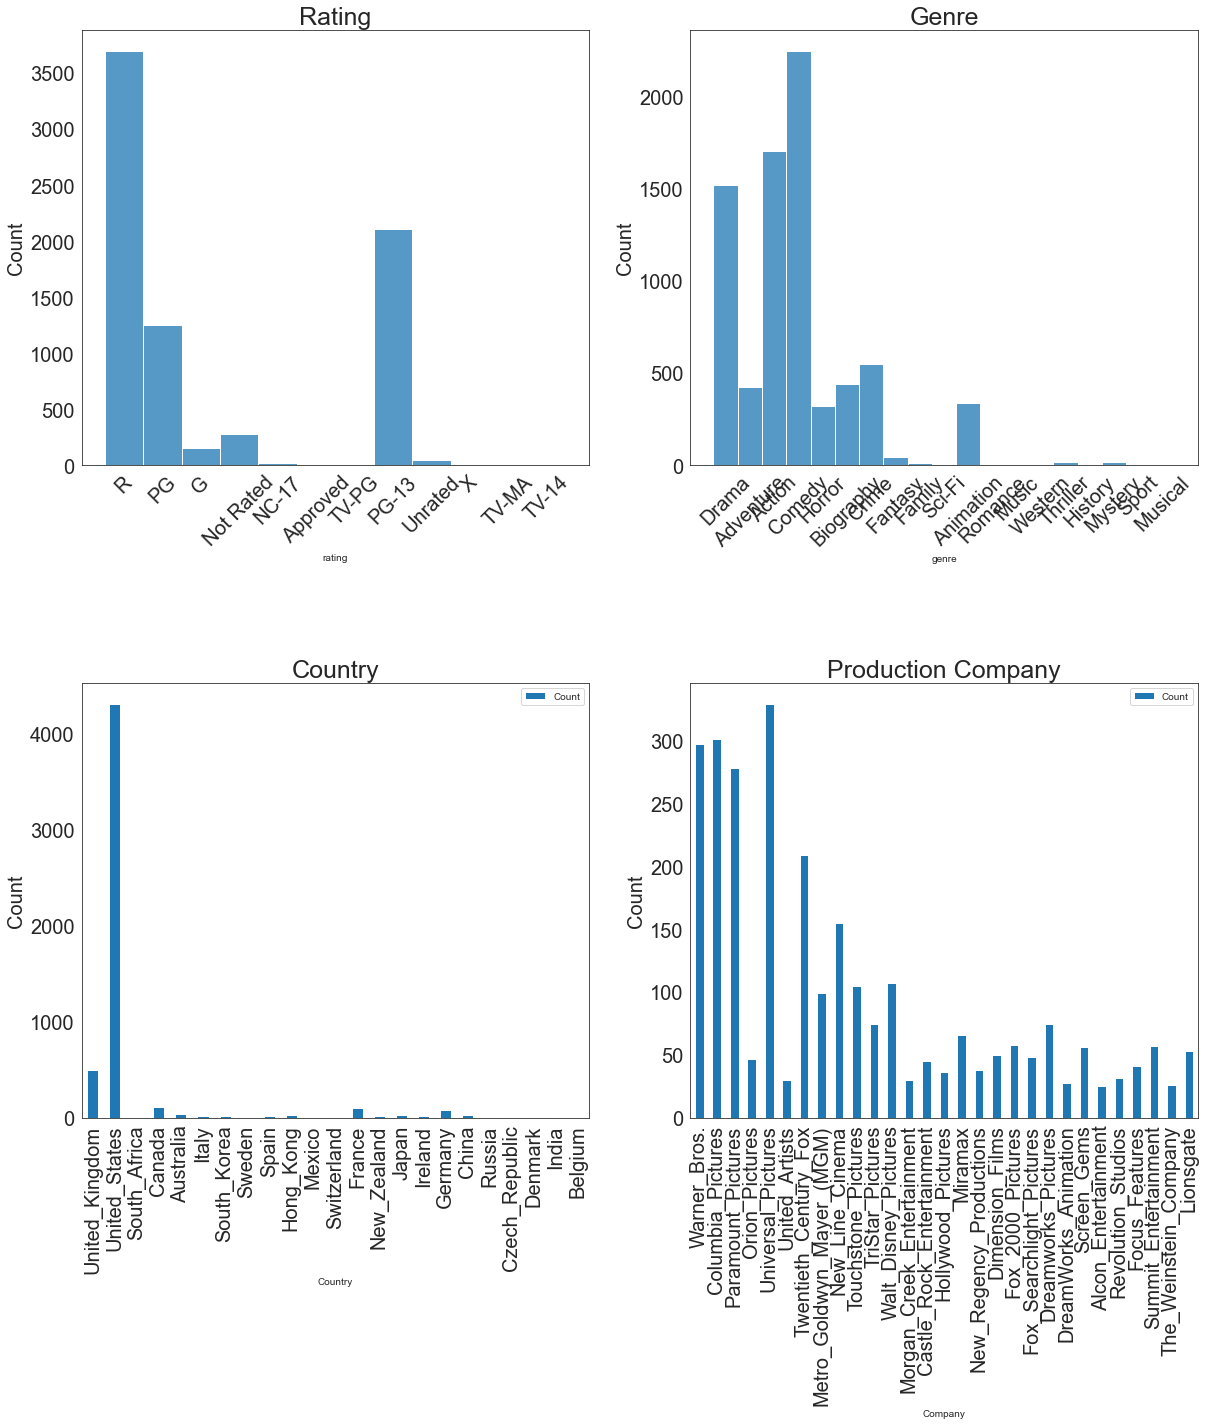

In [303]:
#plotting categoric predictors against count to see distribution
sns.set_style('white')
fig, axes = plt.subplots(2,2,figsize=(20,20))
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.5)

sns.histplot(ax=axes[0,0],x='rating', data = movie_industry)
axes[0,0].set_title('Rating', fontsize=25)
axes[0,0].tick_params(axis = 'both',labelsize=20)
axes[0,0].tick_params(axis='x', labelrotation=45)
axes[0,0].set_ylabel('Count', fontsize=20)

sns.histplot(ax=axes[0,1], x='genre', data = movie_industry)
axes[0,1].set_title('Genre', fontsize=25)
axes[0,1].tick_params(axis = 'both',labelsize=20)
axes[0,1].tick_params(axis='x', labelrotation=45)
axes[0,1].set_ylabel('Count', fontsize=20)

repeated_countries.plot.bar(ax=axes[1,0], x='Country', y='Count')
axes[1,0].set_title('Country', fontsize=25)
axes[1,0].tick_params(axis = 'both',labelsize=20)
axes[1,0].tick_params(axis='x', labelrotation=90)
axes[1,0].set_ylabel('Count', fontsize=20)

repeated_companies.plot.bar(ax=axes[1,1], x='Company', y='Count')
axes[1,1].set_title('Production Company', fontsize=25)
axes[1,1].tick_params(axis = 'both',labelsize=20)
axes[1,1].tick_params(axis='x', labelrotation=90)
axes[1,1].set_ylabel('Count', fontsize=20)

In [304]:
predictors = list(movie_industry.columns)
predictors.remove('gross')
predictors.remove('name')

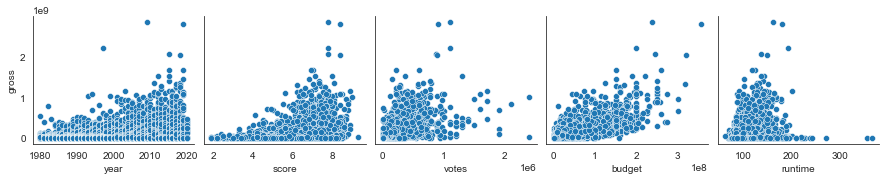

In [305]:
#...Association of the response with the predictors...#
sns.pairplot(movie_industry, y_vars=['gross'], x_vars=continuous)

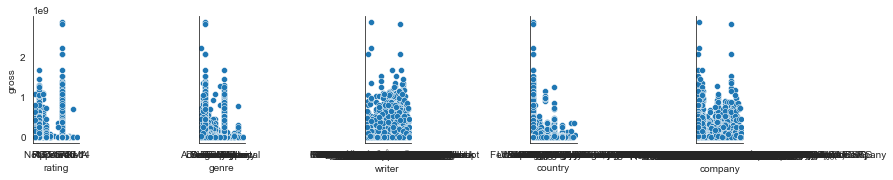

In [308]:
sns.pairplot(movie_industry, y_vars=['gross'], x_vars=categorical)

### Data cleaning
*By Lilly Sorkin*

From the data quality check we realized that:
1. After spending several hours working on it, we discovered that our initial dataset was too dificult to clean. It contained a multitude of listed dictionaries that we were unable to extract information from. As such we turned to our da

2. Some of the columns that we were expecting to be highly important were missing values. For example `budget` was missing 2171 values. Since imputing these values would not provide helpful information for our model, we removed all rows with missing values, leaving us with 5421 data points for our model development.

The code below implements the above cleaning.

In [309]:
movie_industry = pd.read_csv('movies.csv')

In [310]:
#checking for null values
movie_industry.isnull().sum()

name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64

In [311]:
#dropping rows with null values
movie_industry_clean = movie_industry.dropna()
movie_industry_clean.reset_index(inplace=True)

In [312]:
movie_industry_clean.describe()

,index,year,score,votes,budget,gross,runtime
count,5421.000000,5421.000000,5421.000000,5.421000e+03,5.421000e+03,5.421000e+03,5421.000000
mean,4069.060505,2001.661317,6.392455,1.150661e+05,3.600917e+07,1.032297e+08,108.152739
std,2097.297246,10.540908,0.962730,1.844073e+05,4.157337e+07,1.873027e+08,18.115698
min,0.000000,1980.000000,1.900000,1.950000e+02,6.000000e+03,3.090000e+02,63.000000
25%,2389.000000,1993.000000,5.800000,1.900000e+04,1.000000e+07,1.073640e+07,95.000000
50%,4187.000000,2002.000000,6.500000,5.200000e+04,2.180000e+07,3.686941e+07,105.000000
75%,5844.000000,2011.000000,7.100000,1.290000e+05,4.500000e+07,1.124625e+08,118.000000
max,7652.000000,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,271.000000


### Data preparation
*By Lilly Sorkin and Aarti Pappu*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict gross, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. These variables were `month`, `continent`, `decade`.


In [ ]:
def wrangling(df):
    df = df.drop('Unnamed: 0', axis=1)
    df = df.drop('index', axis=1)
    df.replace(' ', '_', regex=True, inplace = True)
    df.replace('-', '_', regex=True, inplace = True)
    return df

movies = wrangling(movie_industry)

In [313]:
# data wrangling
def wrangling(df):
    df.replace(' ', '_', regex=True, inplace = True)
    df.replace('-', '_', regex=True, inplace = True)
    return df

movies = wrangling(movie_industry_clean)

/var/folders/gx/rnh895q11cb5zsdbh368424h0000gn/T/ipykernel_47086/2905906519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(' ', '_', regex=True, inplace = True)
/var/folders/gx/rnh895q11cb5zsdbh368424h0000gn/T/ipykernel_47086/2905906519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('-', '_', regex=True, inplace = True)


In [314]:
#creating a month variable
movies['month'] = movies.released.str.split().str.get(0)

/var/folders/gx/rnh895q11cb5zsdbh368424h0000gn/T/ipykernel_47086/4042592423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['month'] = movies.released.str.split().str.get(0)


In [315]:
# grouping countries into continents
def continent(s):
    if s['country'] in ['United_States','Mexico', 'Canada','Jamaica']:
        return 'North_America'
    if s['country'] in ['United_Kingdom', 'France', 'Germany', 'Belgium','Spain', 'Norway', 'Iceland', 'West_Germany', 'Ireland', 'Italy', 'Finland', 'Czech_Republic', 'Switzerland', 'Sweden', 'Denmark', 'Netherlands','Federal_Republic_of_Yugoslavia','Yugoslavia', 'Hungary', 'Republic_of_Macedonia', 'Austria','Portugal','Malta']:
        return 'Europe'
    if s['country'] in ['Japan','China','South_Korea', 'Hong_Kong','India','United_Arab_Emirates','Taiwan','Lebanon','Indonesia', 'Iran','Israel','Russia','Thailand']:
        return 'Asia'
    if s['country'] in ['Australia','New_Zealand']:
        return 'Oceania'
    if s['country'] in ['South_Africa', 'Kenya']:
        return 'Africa'
    if s['country'] in ['Brazil', 'Argentina', 'Aruba', 'Chile', 'Panama','Colombia']:
        return 'South_America'
    else:
        return 'NA'

movies['continent'] = movies.apply(continent, axis=1)

/var/folders/gx/rnh895q11cb5zsdbh368424h0000gn/T/ipykernel_47086/866166174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['continent'] = movies.apply(continent, axis=1)


In [316]:
# grouping years into decades
def decade(s):
    if s['year'].startswith('198'):
        return 'eighties'
    if s['year'].startswith('199'):
        return 'nineties'
    if s['year'].startswith('200'):
        return 'two_thousands'
    if s['year'].startswith('201'):
        return 'twenty_tens'
    if s['year'].startswith('202'):
        return 'twenty_twenties'
    else:
        return 'NA'

movies['year'] = movies['year'].astype(str)
movies['decade'] = movies.apply(decade, axis=1)
movies['year'] = pd.to_numeric(movies['year'])
movies['year'] = movies['year'].astype(int)

/var/folders/gx/rnh895q11cb5zsdbh368424h0000gn/T/ipykernel_47086/232710534.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['year'] = movies['year'].astype(str)
/var/folders/gx/rnh895q11cb5zsdbh368424h0000gn/T/ipykernel_47086/232710534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['decade'] = movies.apply(decade, axis=1)
/var/folders/gx/rnh895q11cb5zsdbh368424h0000gn/T/ipykernel_47086/232710534.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [317]:
# split into training & test
np.random.seed(2)
train = movies.sample(round(movies.shape[0]*0.8)) # 80%
test = movies.drop(train.index)

# Resetting the indices for both test and train
train = train.reset_index()
train = train.drop(['index'], axis=1)
test = test.reset_index()
test = test.drop(['index'], axis=1)

In [318]:
def dummies_for_categorical_variables(df):
    rating_dummy = pd.get_dummies(df['rating'])
    df = pd.concat([df, rating_dummy], axis=1)
    df = df.drop('rating', axis=1)
    genre_dummy = pd.get_dummies(df['genre'])
    df = pd.concat([df, genre_dummy], axis=1)
    df = df.drop('genre', axis=1)
    continent_dummy = pd.get_dummies(df['continent'])
    df = pd.concat([df, continent_dummy], axis=1)
    df = df.drop('continent', axis=1)
    decade_dummy = pd.get_dummies(df['decade'])
    df = pd.concat([df, decade_dummy], axis=1)
    df = df.drop('decade', axis=1)
    month_dummy = pd.get_dummies(df['month'])
    df = pd.concat([df, month_dummy], axis=1)
    df = df.drop('month', axis=1)
    return df

train_variable_selection = dummies_for_categorical_variables(train)
test = dummies_for_categorical_variables(test)

In [319]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [ ]:
######-----------Shuffling the dataset for K-fold------------#########

In [ ]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

isabel

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [ ]:
artharva, aarti

We first wanted to visualize the 

In [301]:
ols_object = smf.ols(formula = 'gross~month+budget+genre+rating+votes+continent+runtime+score+year', data = train)
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     5.814
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          1.04e-314
Time:                        05:31:49   Log-Likelihood:                -84296.
No. Observations:                4337   AIC:                         1.733e+05
Df Residuals:                    2007   BIC:                         1.881e+05
Df Model:                        2329                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          3.788e+08   1.18e+10      0.032      0.974   -2.28e+10    2.36e+10
month[T.1987_(United_States)]                     -5.069e+07   1.53e+08     -0.332      0.740    -3.5e+08    2.49e+08
month[T.1995_(Iran)]                               2.404e+07   1.72e+08      0.140      0.889   -3.12e+08    3.61e+08
month[T.2019_(United_States)]                      7.373e+07   1.84e+08      0.401      0.688   -2.87e+08    4.34e+08
month[T.April_1,_1983_(United_States)]             4.252e+07   1.39e+08      0.305      0.761   -2.31e+08    3.16e+08
month[T.April_1,_1988_(United_States)]              1.71e+07   1.44e+08      0.119      0.905   -2.65e+08    2.99e+08
month[T.April_1,_2005_(United_States)]            -5.216e+07   1.83e+08     -0.285      0.775   -4.11e+08    3.06e+08
month[T.April_1,_2016_(United_States)]              4.82e+07   2.33e+08      0.207      0.836    -4.1e+08    5.06e+08
month[T.April_10,_1981_(United_States)]            5.037e+07   1.14e+08      0.441      0.659   -1.73e+08    2.74e+08
month[T.April_10,_1987_(United_States)]            9.722e+07   1.42e+08      0.683      0.495   -1.82e+08    3.77e+08
month[T.April_10,_1992_(United_States)]           -5.444e+06   1.29e+08     -0.042      0.966   -2.59e+08    2.48e+08
month[T.April_10,_1998_(United_States)]            7.324e+07   1.69e+08      0.434      0.664   -2.58e+08    4.04e+08
month[T.April_10,_2009_(United_States)]            6.868e+07      2e+08      0.343      0.732   -3.24e+08    4.62e+08
month[T.April_10,_2015_(United_States)]            6.221e+07   2.26e+08      0.275      0.784   -3.82e+08    5.06e+08
month[T.April_11,_1986_(United_Kingdom)]           7.386e+07   1.47e+08      0.502      0.615   -2.15e+08    3.62e+08
month[T.April_11,_1986_(United_States)]            3.454e+07   1.23e+08      0.281      0.779   -2.07e+08    2.76e+08
month[T.April_11,_1997_(Brazil)]                   1.802e+07   1.63e+08      0.111      0.912   -3.01e+08    3.37e+08
month[T.April_11,_1997_(United_States)]              4.7e+07   1.51e+08      0.312      0.755   -2.49e+08    3.43e+08
month[T.April_11,_2003_(United_States)]           -1.894e+07   1.87e+08     -0.101      0.919   -3.85e+08    3.47e+08
month[T.April_11,_2008_(United_Kingdom)]           3.197e+07   2.09e+08      0.153      0.878   -3.77e+08    4.41e+08
month[T.April_11,_2014_(United_States)]            6.961e+07   2.18e+08      0.319      0.750   -3.59e+08    4.98e+08
month[T.April_12,_1985_(United_States)]            2.178e+07   1.22e+08      0.178      0.858   -2.18e+08    2.61e+08
month[T.April_12,_1991_(United_States)]            6.567e+07   1.49e+08      0.440      0.660   -2.27e+08    3.58e+08
month[T.April_1

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [ ]:
aaarti, artharva

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.

In [ ]:
artharva